In [1]:
# Analysis can be run locally and then migrate to crunchy
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.metrics import root_mean_squared_error
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from xgboost import plot_importance

# Load Training Data

In [33]:
directory = r'C:\Users\yingl\OneDrive\Desktop\MultiorePerformancePrediction\MultiorePerformancePrediction\data\training_data'

def collect_training_data(directory = ''):
    lst = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                lst.append(pd.read_csv(os.path.join(root, file)))
    
    df_raw = pd.concat(lst)
    print(f'length starts: {len(df_raw)}')
    for col in ['branch-instructions', 'branch-misses', 'cache-misses', 'cache-references', 'cpu-cycles', 'instructions', 
                'stalled-cycles-frontend', 'L1-icache-load-misses', 'LLC-load-misses', 'LLC-loads', 'LLC-stores', 
                'L1-dcache-prefetch-misses', 'L1-dcache-prefetches', 'L1-icache-loads',
                'branch-load-misses', 'branch-loads', 'dTLB-load-misses', 'dTLB-loads', 'iTLB-load-misses', 'iTLB-loads']:
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    #df_raw.to_csv('training_data_all.csv', index=False)
    #df_raw[numeric_feature_lst].corr().to_csv('corr.csv')
    return df_raw

df_raw = collect_training_data(directory)

# def f(row):
#     if any([row['run_id'].startswith(i) for i in ['bfs', 'lavaMD', 'kmeans', 'myocyte']]):
#         return 'rodinia'
#     else:
#         return 'parsec'

# # df_raw['benchmark'] = df_raw.apply(f, axis=1)

df_raw['runtime_serial'] = df_raw['speed_up'] * df_raw['compute_time']
df_raw['IPC'] = df_raw['instructions'] / df_raw['cpu-cycles']
df_raw['IPS'] = df_raw['instructions'] / df_raw['compute_time']

length starts: 2386


In [3]:
print(set(df_raw['hostname']))

{'snappy1', 'crackle3', 'crunchy1', 'cuda1', 'crunchy6', 'crackle1', 'crackle5', 'crunchy5'}


## Anomaly Detection

C:\Users\yingl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



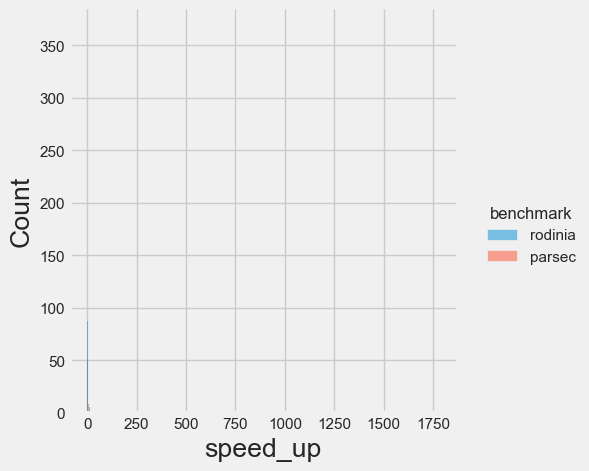

In [34]:
sns.displot(df_raw[['speed_up', 'benchmark']], x="speed_up", hue="benchmark")
plt.show()

C:\Users\yingl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



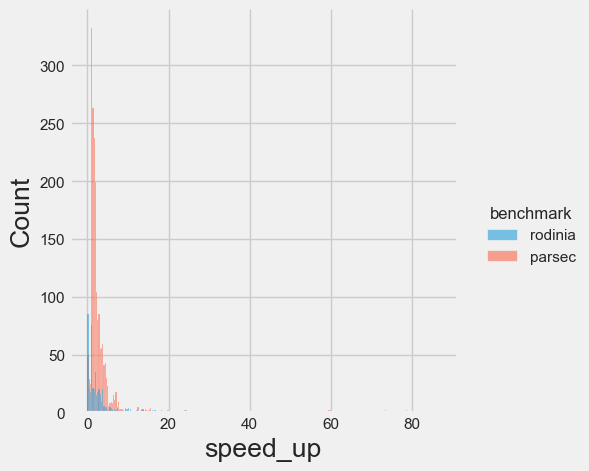

In [35]:
df_raw = df_raw.loc[df_raw['speed_up'] <= 100]
sns.displot(df_raw[['speed_up', 'benchmark']], x="speed_up", hue="benchmark")
plt.show()

<Axes: xlabel='threads', ylabel='speed_up'>

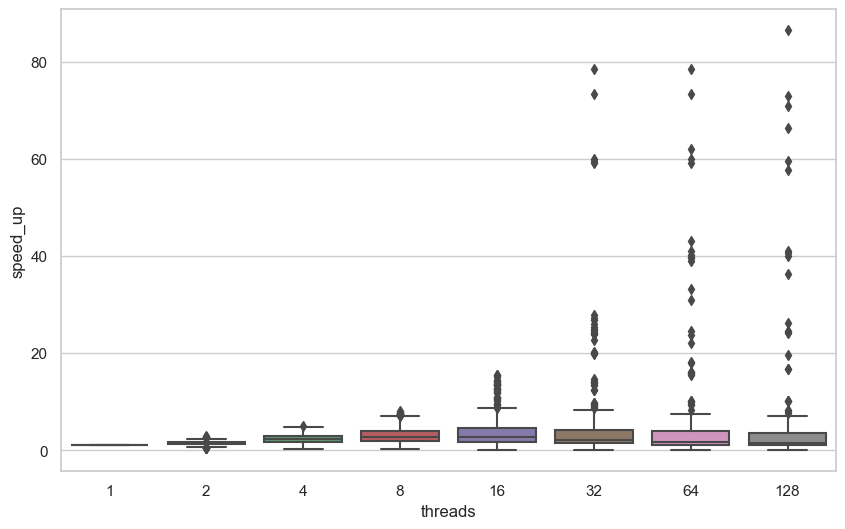

In [5]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid') 
sns.boxplot(x="threads",
                y="speed_up",
                data=df_raw[['speed_up', 'threads', 'benchmark']])

## Missing Data

In [6]:
class_feature_lst = []
numeric_feature_lst = []

for col in list(df_raw): 
    null_pct = df_raw[col].isnull().sum() / len(df_raw)
    if null_pct <= 0.2:
        #print(col, null_pct, df_raw.dtypes[col], df_raw.iloc[0])
        if df_raw.dtypes[col] == 'object':
            class_feature_lst.append(col)
        else:
            numeric_feature_lst.append(col)

numeric_feature_lst.remove('speed_up')
numeric_feature_lst.remove('compute_time')
print(numeric_feature_lst)
print(class_feature_lst)

['branch-instructions', 'branch-misses', 'cache-misses', 'cache-references', 'cpu-cycles', 'instructions', 'stalled-cycles-frontend', 'alignment-faults', 'bpf-output', 'context-switches', 'cpu-clock', 'cpu-migrations', 'dummy', 'emulation-faults', 'major-faults', 'minor-faults', 'page-faults', 'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads', 'L1-dcache-prefetch-misses', 'L1-icache-load-misses', 'LLC-load-misses', 'LLC-loads', 'LLC-stores', 'branch-load-misses', 'branch-loads', 'dTLB-load-misses', 'dTLB-loads', 'iTLB-load-misses', 'iTLB-loads', 'msr/aperf/', 'msr/mperf/', 'msr/tsc/', 'threads', 'host_cpu_user', 'host_cpu_system', 'host_cpu_idle', 'host_memused', 'CPU(s)', 'Thread(s) per core', 'Core(s) per socket', 'Socket(s)', 'NUMA node(s)', 'CPU family', 'Model', 'Stepping', 'CPU MHz', 'BogoMIPS', 'runtime_serial', 'IPC', 'IPS']
['size', 'run_time', 'benchmark', 'run_id', 'program', 'hostname', 'Architecture', 'CPU op-mode(s)', 'Byte Order', 'On-line CPU(s) list', 'Vendor ID

# Feature Examine

length after dropping: 2012


C:\Users\yingl\AppData\Local\Temp\ipykernel_3232\2929058954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


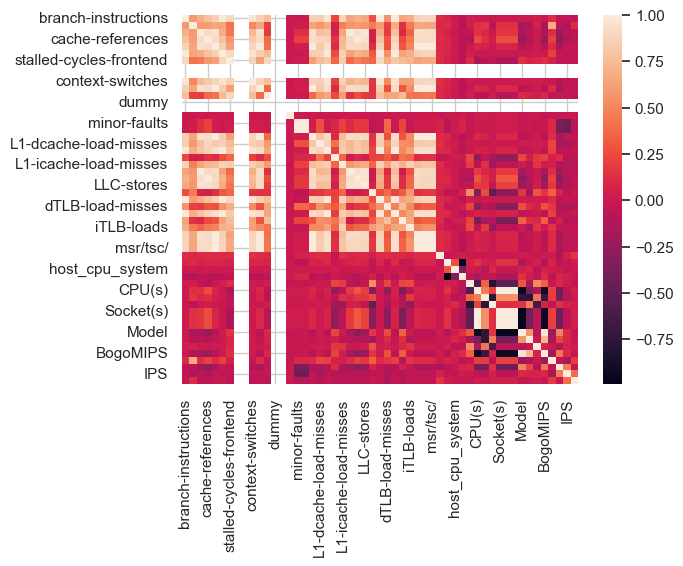

In [7]:
# take out null
df = df_raw[numeric_feature_lst + ['speed_up']]
sns.heatmap(df.corr())
# for col in list(df):
#     df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
print(f'length after dropping: {len(df)}')

# return df
# df = preprocess_training(df_raw)

## Numerical Feature (p value)

In [8]:
X = df[numeric_feature_lst]
y = df['speed_up']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               speed_up   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     38.00
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          3.62e-216
Time:                        18:34:03   Log-Likelihood:                -6058.4
No. Observations:                2012   AIC:                         1.220e+04
Df Residuals:                    1970   BIC:                         1.244e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Categorical Feature (chi test)

In [9]:
for to_test in class_feature_lst:
    # Create a DataFrame
    #to_test = 'Architecture'
    df_cat_test = df_raw[['speed_up', to_test]]
    
    # Create a contingency table
    table = pd.crosstab(df_cat_test[to_test], df_cat_test['speed_up'])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(table)
    
    # Interpret the results
    if p < 0.1:
        print('Y --', to_test, p)
    else:
        print('N --', to_test, p)

N -- size 0.3432287395859039
N -- run_time 0.2551846932496198
N -- benchmark 0.37945629762034616
Y -- run_id 0.05482759270293965
N -- program 0.25787193328181807
N -- hostname 0.3079617275244728
N -- Architecture 1.0
N -- CPU op-mode(s) 1.0
N -- Byte Order 1.0
N -- On-line CPU(s) list 0.3589508395144156
N -- Vendor ID 0.42522772506343126
N -- Model name 0.3589508395144187
N -- Virtualization 0.42522772506343126
N -- L1d cache 0.42522772506343126
N -- L1i cache 0.42522772506343126
N -- L2 cache 0.42522772506343126
N -- L3 cache 0.3589508395144156
N -- NUMA node0 CPU(s) 0.3589508395144156
N -- NUMA node1 CPU(s) 0.3589508395144156
N -- total_memory 0.3870466746310222


## PCA for Virtulization

In [10]:
df_pca = df_raw[numeric_feature_lst + ['benchmark']]
df_pca.dropna(inplace=True)

d = {}
d['data'] = df_pca[numeric_feature_lst]
d['benchmark'] = df_pca['benchmark']

C:\Users\yingl\AppData\Local\Temp\ipykernel_3232\1446170956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.dropna(inplace=True)


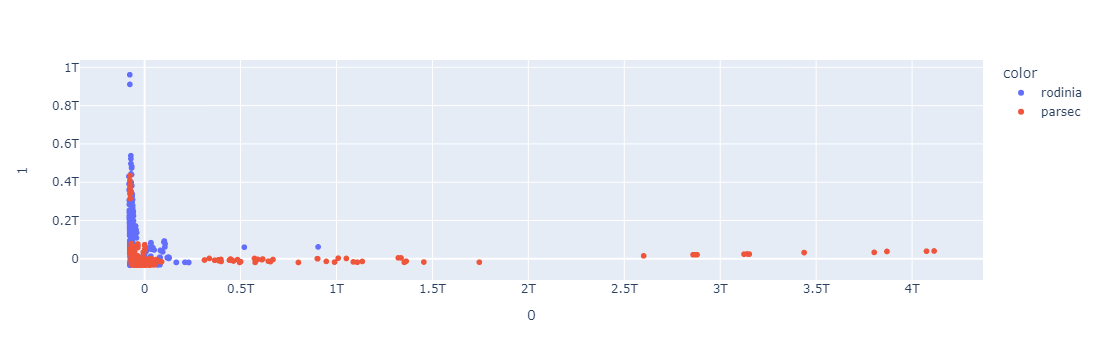

In [11]:
pca = PCA(n_components=2)
components = pca.fit_transform(d['data'])

fig = px.scatter(components, x=0, y=1, color=d['benchmark'])
fig.show()

# Preprocess data

## Train Test Split

In [12]:
df_tmp = df_raw[numeric_feature_lst + ['speed_up', 'hostname']]
df_tmp.dropna(inplace=True)

df_train = df_tmp.loc[df_tmp['hostname'] != 'crunchy6']
df_test = df_tmp.loc[df_tmp['hostname'] == 'crunchy6']

print(f'df_train length {len(df_train)}, df_test length {len(df_test)}')

X_train = df_train[numeric_feature_lst]
y_train = df_train['speed_up']
X_test = df_train[numeric_feature_lst]
y_test = df_train['speed_up']

df_train length 1789, df_test length 223


C:\Users\yingl\AppData\Local\Temp\ipykernel_3232\2859809040.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
X_train_random = X_train.copy()
X_test_random = X_test.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])
X_test_random["RANDOM"] = np.random.RandomState(42).randn(X_test.shape[0])

In [14]:
numeric_selected_feature_lst = ['CPU(s)','cpu-cycles','host_memused','dTLB-loads','L1-dcache-loads','instructions','branch-loads',
'Stepping','CPU MHz','LLC-stores','LLC-load-misses','CPU family','BogoMIPS','branch-load-misses','context-switches','cache-misses',
'cpu-migrations','iTLB-loads','msr/mperf/','branch-instructions','task-clock','L1-dcache-prefetch-misses',
#'compute_time',
'msr/tsc/','threads','cpu-clock','branch-misses','stalled-cycles-frontend','minor-faults','L1-icache-load-misses','dTLB-load-misses',
'iTLB-load-misses','page-faults','L1-dcache-load-misses','LLC-loads','IPC','cache-references','runtime_serial','IPS',]

df_tmp_2 = df_raw[numeric_selected_feature_lst + ['speed_up', 'hostname']]
df_tmp_2.dropna(inplace=True)

df_train_limited = df_tmp_2.loc[df_tmp_2['hostname'] != 'crunchy6']
df_test_limited = df_tmp_2.loc[df_tmp_2['hostname'] == 'crunchy6']

print(f'df_train length {len(df_train)}, df_test length {len(df_test)}')

X_train_limited = df_train_limited[numeric_selected_feature_lst]
y_train_limited = df_train_limited['speed_up']
X_test_limited = df_train_limited[numeric_selected_feature_lst]
y_test_limited = df_train_limited['speed_up']

df_train length 1789, df_test length 223


C:\Users\yingl\AppData\Local\Temp\ipykernel_3232\1213373557.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Normalization

In [15]:
scaler = StandardScaler().fit(X_train) 
X_train_std = scaler.transform(X_train) 
X_test_std = scaler.transform(X_test) 

# Prediction

## 1) Linear Regression

### 1.1) Linear Regression with selected features

In [16]:
# def predict_regression(df):
#     X = df[numeric_feature_lst]
#     y = df['speed_up']

#     # Split the DataFrame into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     # Create a scikit-learn model
#     model = LinearRegression()

#     # Fit the model to the training data
#     model.fit(X_train, y_train)

#     # Make predictions on the testing data
#     y_pred = model.predict(X_test) # need to cap it >= 0

#     # Evaluate the model's performance
#     print('model.score', model.score(X_test, y_test))
#     # print('RMSE', root_mean_squared_error(y_test, y_pred))
#     print('MSE', mean_squared_error(y_test, y_pred))
#     print('MAE', mean_absolute_error(y_test, y_pred))

# predict_regression(df)

model.score 0.4979001246573479
MSE 18.242684780011178
MAE 2.3168761279023324


In [17]:
def perform_linear_and_ridge_regression(X_train, X_test, y_train, y_test):
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 
    lin_reg_parameters = { 'fit_intercept': [True, False] }
    lin_reg = GridSearchCV(LinearRegression(), lin_reg_parameters, cv=5)
    lin_reg.fit(X=X_train, y=y_train)
    y_pred = lin_reg.predict(X_test)
    # print('model.score', model.score(X_test, y_test))
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

# X_std = transformer.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
perform_linear_and_ridge_regression(X_train, X_test, y_train, y_test)
perform_linear_and_ridge_regression(X_train_std, X_test_std, y_train, y_test)
# perform_linear_and_ridge_regression(X=X, Y=y)

MSE 25.005894442536658
MAE 2.5147693001464377
MSE 25.00589411563432
MAE 2.514777991346199


### 1.2) Linear regression w/ L1 regularization

In [39]:
def perform_lr_l1(X_train, X_test, y_train, y_test):
    reg = linear_model.Lasso(alpha=0.1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

perform_lr_l1(X_train, X_test, y_train, y_test)
perform_lr_l1(X_train_std, X_test_std, y_train, y_test)

MSE 25.60768945481951
MAE 2.429322746724226
MSE 27.44299349467806
MAE 2.429261958331954


C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e+04, tolerance: 7.900e+00



In [19]:
# reg = LassoCV(cv=5, random_state=0).fit(X_train_std, y_train)
# y_pred = reg.predict(X_test_std)
# print('MSRE', mean_squared_error(y_test, y_pred))
# print('MAE', mean_absolute_error(y_test, y_pred))

### 1.3)* Linear regression w/ L2 regularization

In [45]:
def perform_lr_l2(X_train, X_test, y_train, y_test):
    ridgecv = linear_model.RidgeCV(alphas=[0.001, 0.01, 0.1, 0.5, 1, 10], cv=5)
    ridgecv.fit(X_train, y_train) # not converging is not std
    y_pred = ridgecv.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

perform_lr_l2(X_train, X_test, y_train, y_test)
perform_lr_l2(X_train_std, X_test_std, y_train, y_test)

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.89854e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.84954e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.83936e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.8619e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=7.11104e-29): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.31716e-29): result may not be accu

MSE 25.005899196252457
MAE 2.5147004959687855
MSE 26.18330526933311
MAE 2.5363418181455093


C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.25678e-27): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.28161e-27): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=7.12047e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.3178e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.26465e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.25441e-26): result may not be accu

## 2)* KNN 

In [46]:
def perform_knn(X_train, X_test, y_train, y_test):
    #create new a knn model
    knn2 = KNeighborsRegressor()
    #create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 25)}
    #use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
    #fit model to data
    knn_gscv.fit(X_train, y_train)
    rf = KNeighborsRegressor(n_neighbors = knn_gscv.best_params_['n_neighbors'])
    
    y_pred = knn_gscv.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

perform_knn(X_train, X_test, y_train, y_test)
perform_knn(X_train_std, X_test_std, y_train, y_test)

MSE 21.10772933925308
MAE 1.479892729688386
MSE 22.500802348309882
MAE 1.6372768161413311


### w/ Limited Feature

In [47]:
perform_knn(X_train_limited, X_test_limited, y_train, y_test)

MSE 21.10769580393299
MAE 1.4789865451931505


## 3)* Random Forest - Bagging

MSRE 0.44376171941700326
MAE 0.24174782078037232


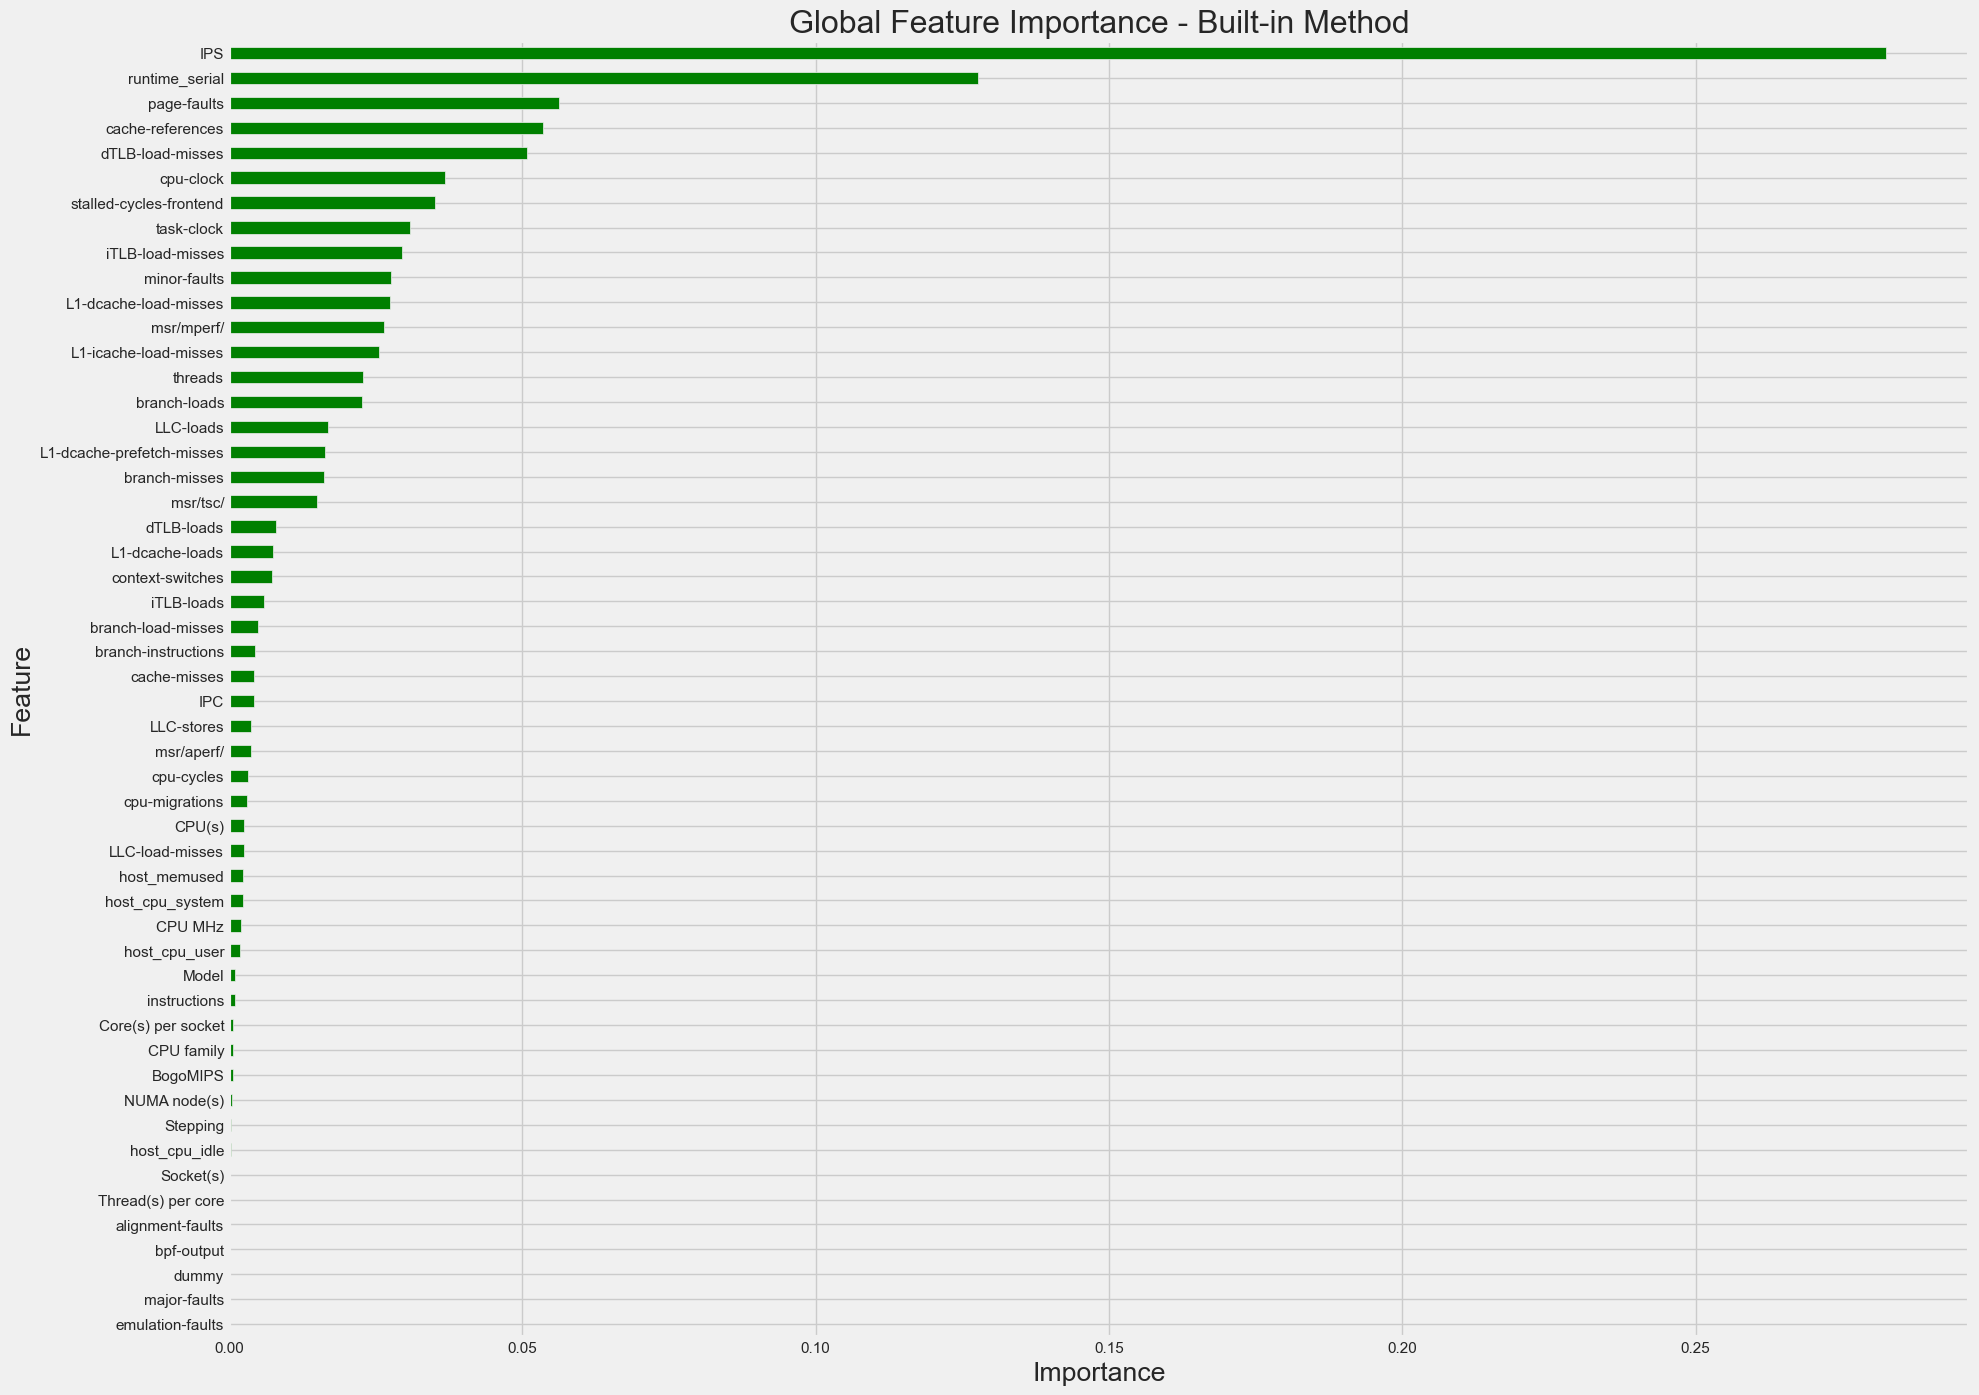

In [48]:
def perform_rf(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': [5,10,20,30],
        'max_features' : [5,10,20,30],
        'n_estimators': [20,50]}
    
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0), 
                               param_grid=param_grid,
                               cv=KFold(n_splits=5, shuffle=True, random_state=1))
    
    grid_search.fit(X_train, y_train)
    rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],
                               max_features = grid_search.best_params_['max_features'],
                               max_depth = grid_search.best_params_['max_depth'],
                               random_state = 0)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    print('MSRE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    
    plt.figure(figsize=(20, 16))
    global_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Global Feature Importance - Built-in Method")

perform_rf(X_train, X_test, y_train, y_test)
# perform_knn(X_train_std, X_test_std, y_train, y_test)

In [23]:
param_grid = {
    'max_depth': [5,10,20,30],
    'max_features' : [5,10,20,30],
    'n_estimators': [20,50]}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0), 
                           param_grid=param_grid,
                           cv=KFold(n_splits=5, shuffle=True, random_state=1))

grid_search.fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           random_state = 0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print('MSRE', mean_squared_error(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))

MSRE 0.44376171941700326
MAE 0.24174782078037232


### RF: Feature Importance

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

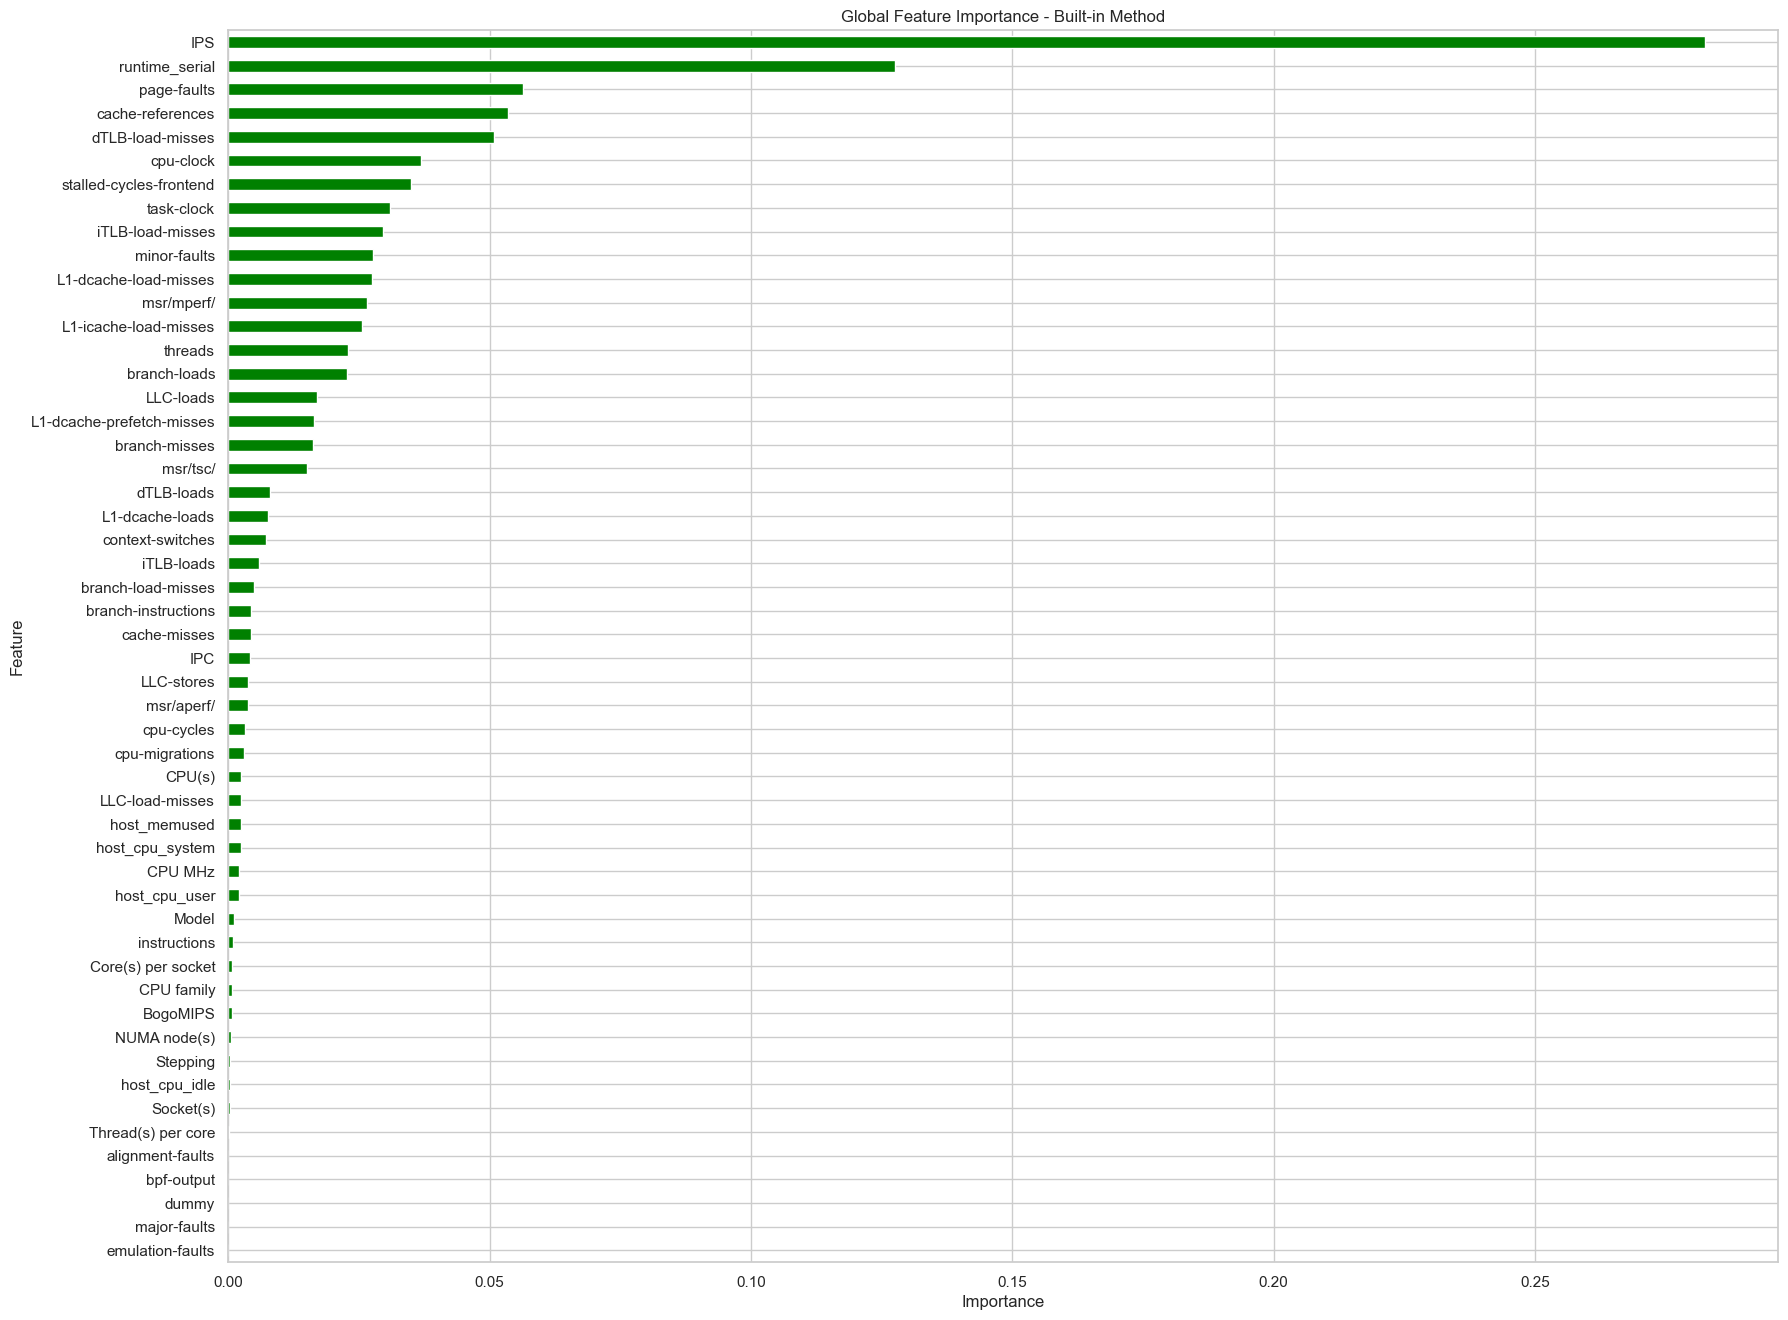

In [24]:
plt.figure(figsize=(20, 16))
global_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

### RF: Feature Importance w/ Random

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

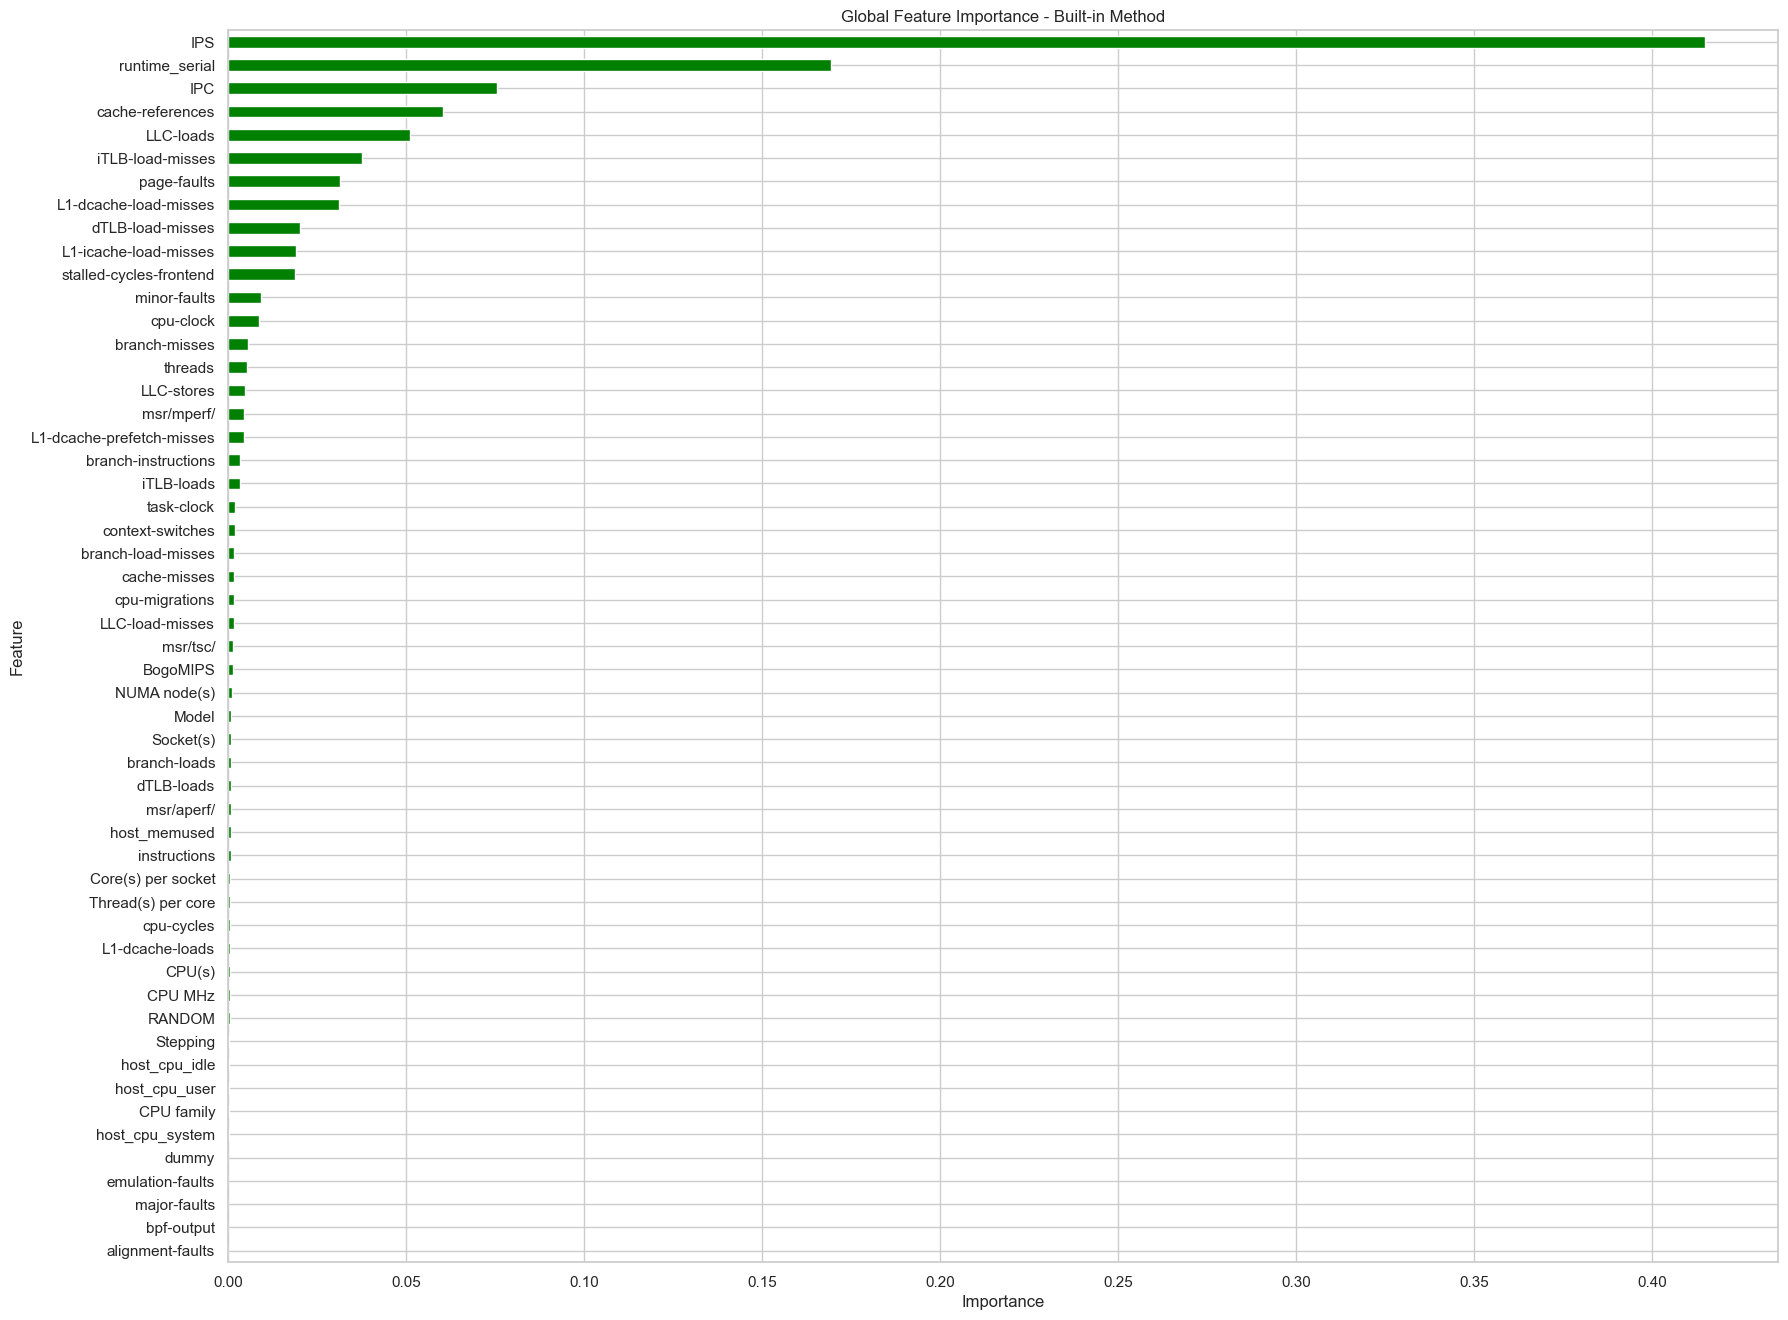

In [25]:
rf_random = RandomForestRegressor(n_estimators=100, random_state=42)
rf_random.fit(X_train_random, y_train)

global_importances_random = pd.Series(rf_random.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)

plt.figure(figsize=(20, 16))
global_importances_random.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [26]:
global_importances_random

alignment-faults             0.000000
bpf-output                   0.000000
major-faults                 0.000000
emulation-faults             0.000000
dummy                        0.000000
host_cpu_system              0.000081
CPU family                   0.000100
host_cpu_user                0.000144
host_cpu_idle                0.000200
Stepping                     0.000279
RANDOM                       0.000337
CPU MHz                      0.000393
CPU(s)                       0.000418
L1-dcache-loads              0.000472
cpu-cycles                   0.000497
Thread(s) per core           0.000555
Core(s) per socket           0.000568
instructions                 0.000621
host_memused                 0.000744
msr/aperf/                   0.000748
dTLB-loads                   0.000760
branch-loads                 0.000789
Socket(s)                    0.000842
Model                        0.000861
NUMA node(s)                 0.000881
BogoMIPS                     0.001205
msr/tsc/    

## 4) Boosting

### 4.1) Gradient Boosting

In [27]:
gb_reg = GradientBoostingRegressor(random_state=0)
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)
# print('RMSE', root_mean_squared_error(y_test, y_pred))
print('MSE', mean_squared_error(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))

MSE 0.18724817486550052
MAE 0.279438407071254


#### Feature Importance

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

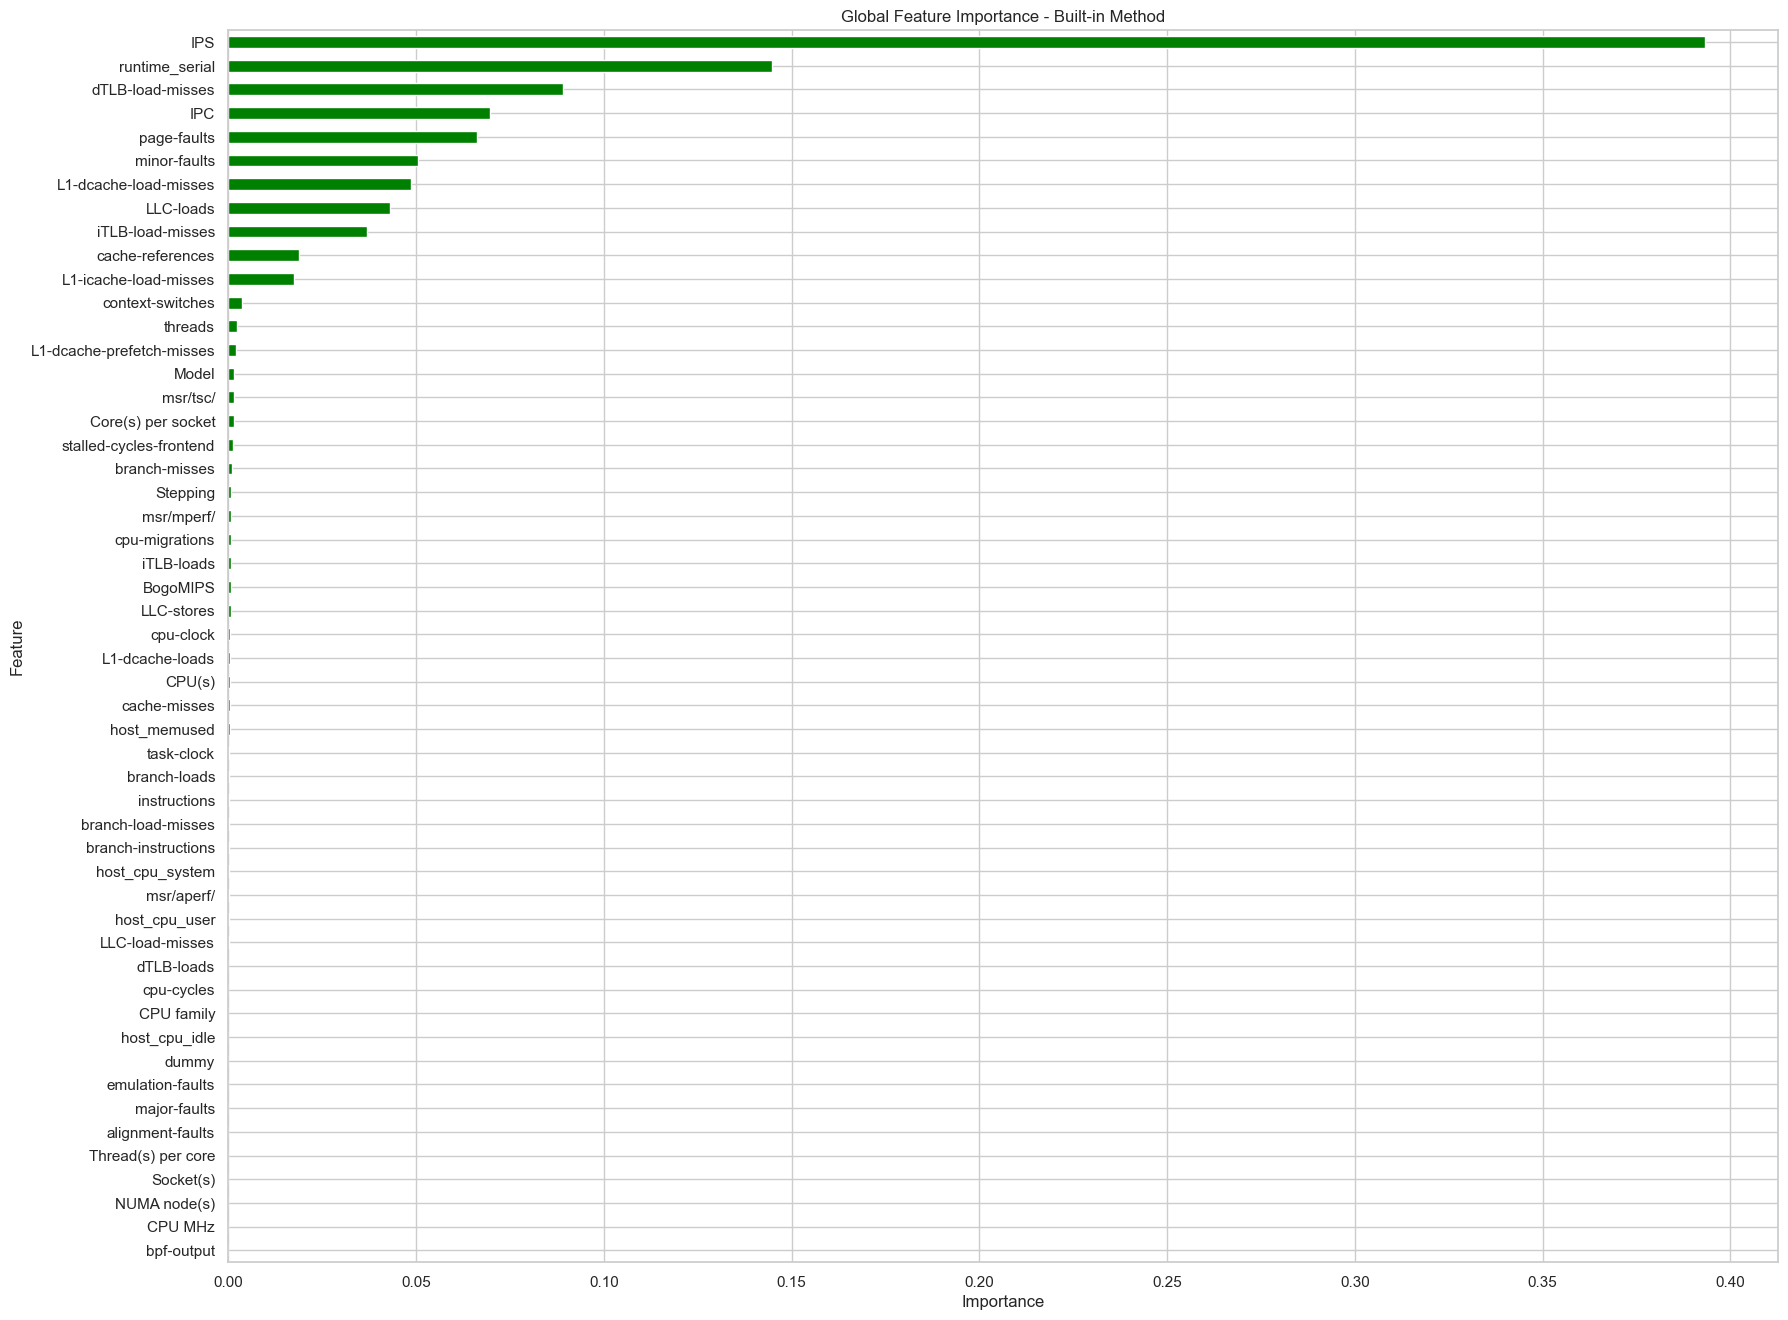

In [28]:
# print(reg.feature_importances_)
plt.figure(figsize=(20, 16))
global_importances = pd.Series(gb_reg.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

### 4.2)* XgBoosting

https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression

In [29]:
xg_regressor=xgb.XGBRegressor(eval_metric='rmsle')
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(xg_regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

xg_regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse') # mae

xg_regressor.fit(X_train, y_train)
predictions = xg_regressor.predict(X_test)

# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MSE 0.10198212402398325
MAE 0.21627655614244323


#### Feature Importance

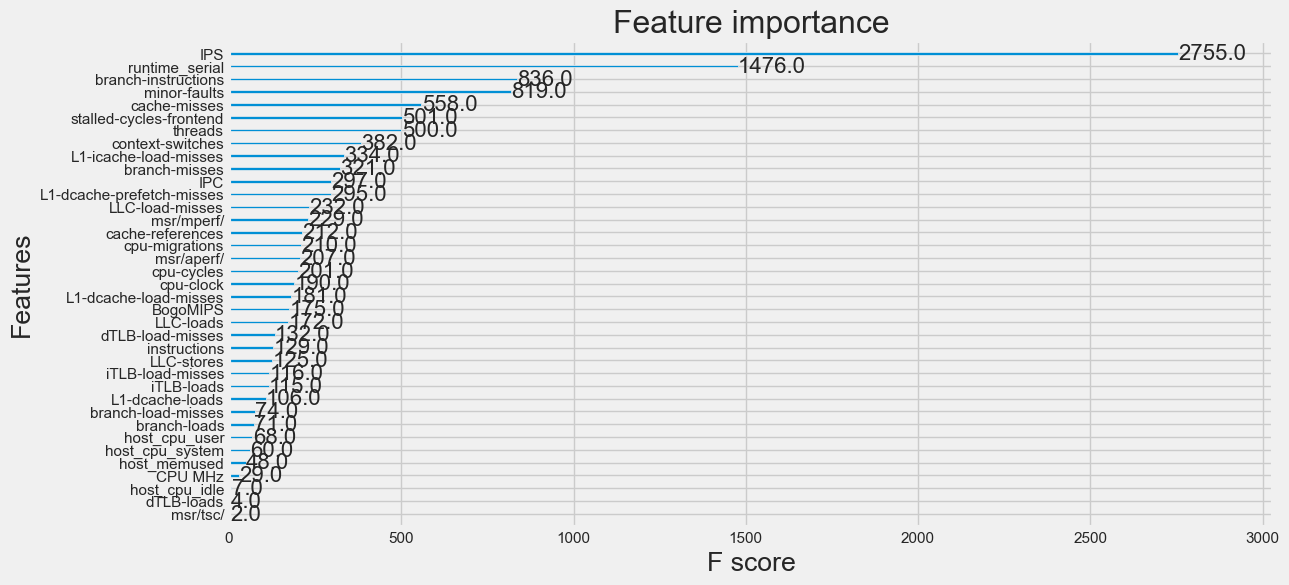

In [30]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xg_regressor, max_num_features=50, ax=ax)
plt.show()

#### Feature Importance w/ Random

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MSE 0.10364247446340999
MAE 0.2178827312170903


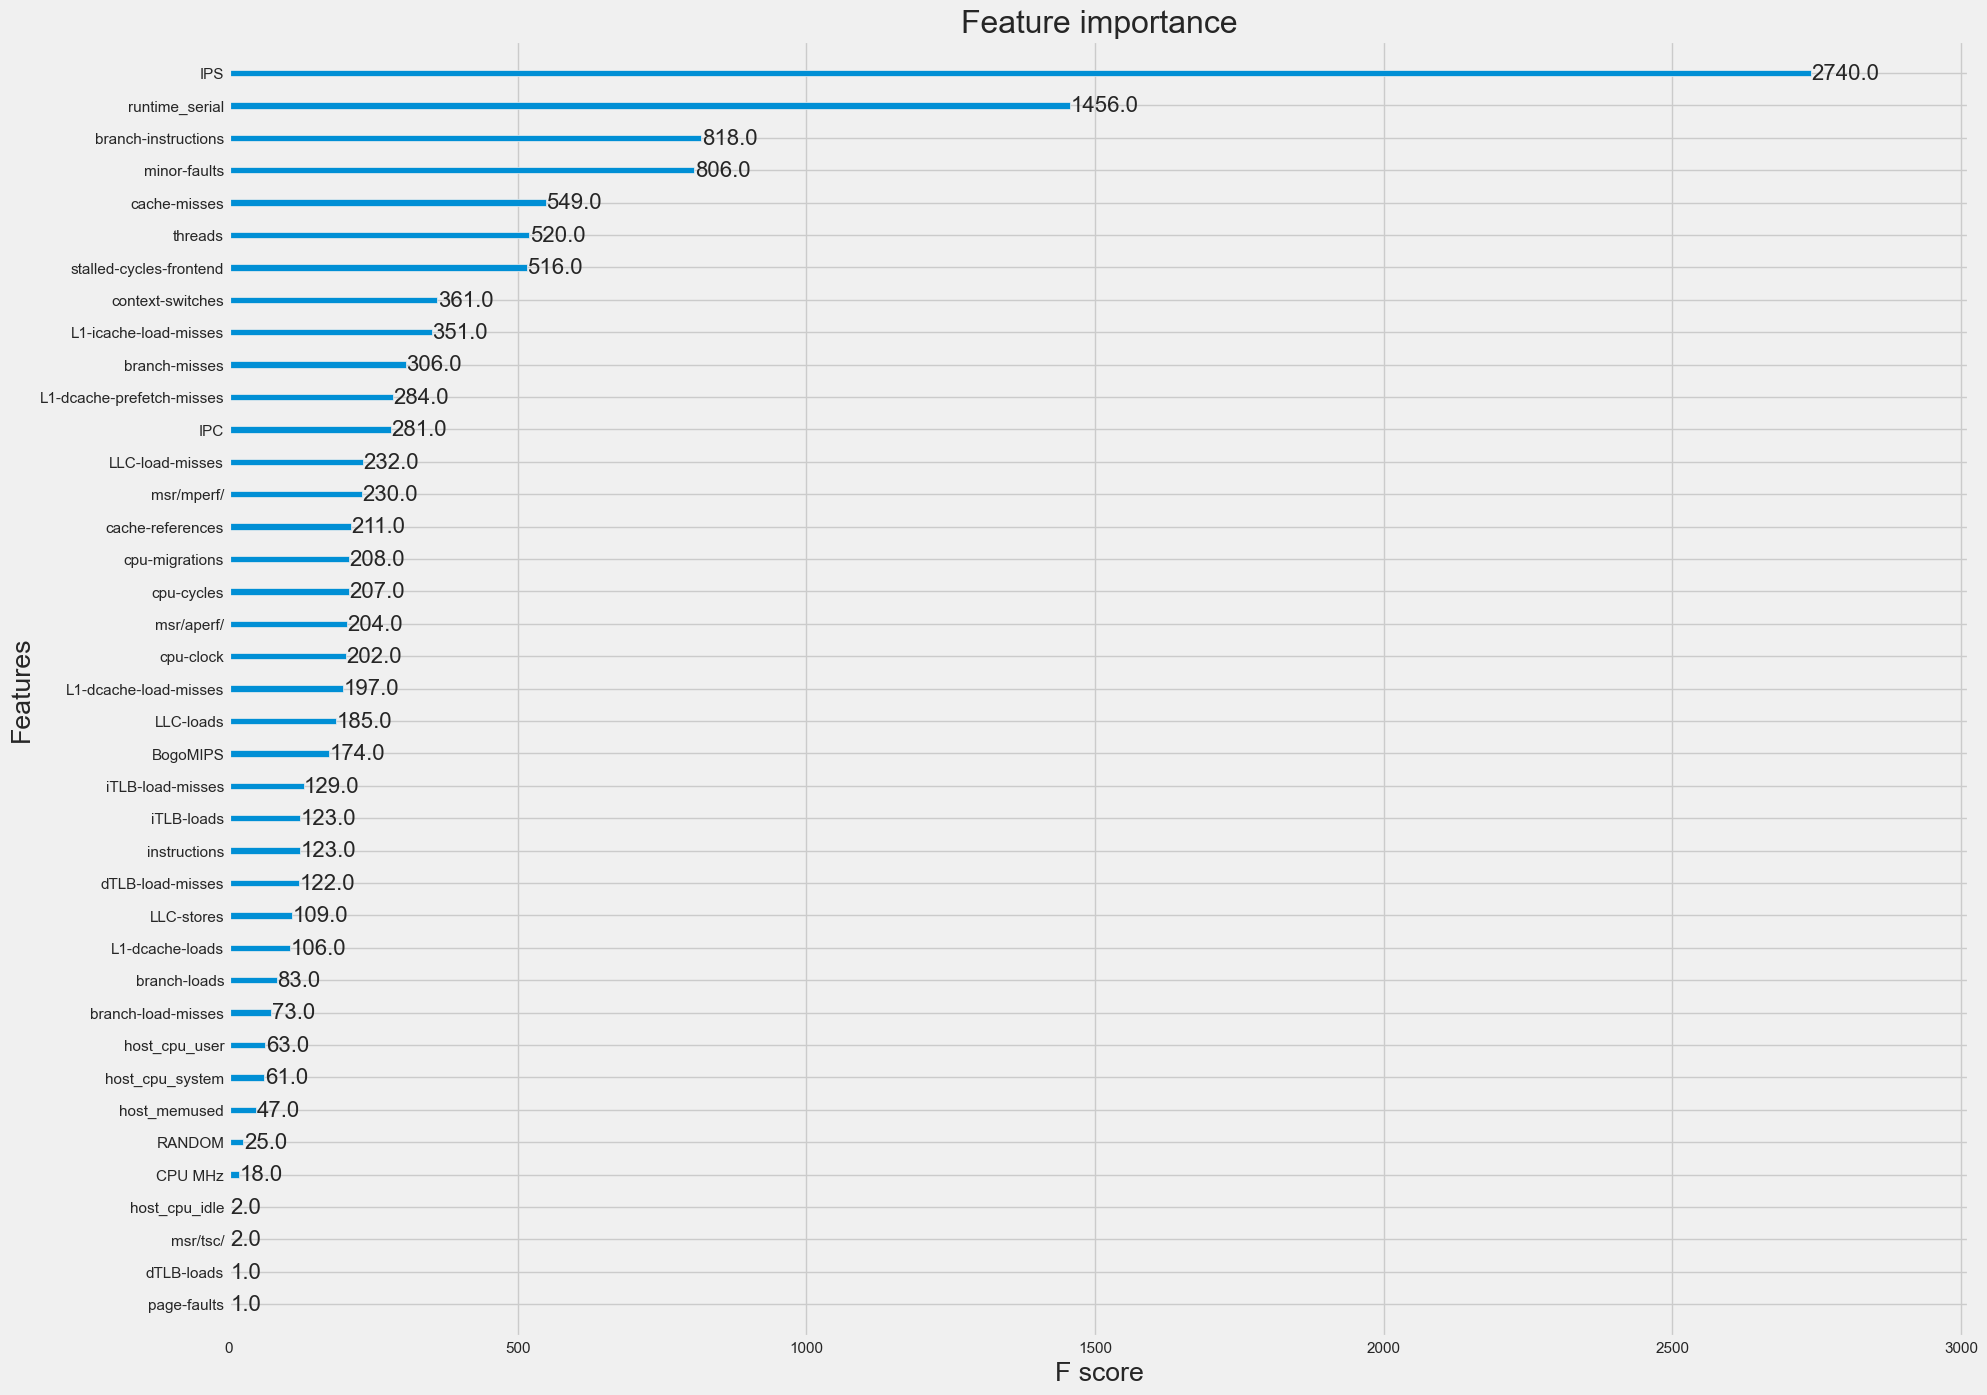

In [31]:
xg_regressor_rn =xgb.XGBRegressor(eval_metric='rmsle')
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(xg_regressor_rn, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

xg_regressor_rn=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

xg_regressor_rn.fit(X_train_random, y_train)
predictions = xg_regressor_rn.predict(X_test_random)

# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(20,16))
plot_importance(xg_regressor_rn, max_num_features=50, ax=ax)
plt.show()

## (optional) Neural Network

In [32]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))

MSE 37.23002765746091
MAE 2.484375545276492
